In [1]:
library(data.table)
library(dplyr)
library(BuenColors)
library(stringr)
library(cowplot)
library(SummarizedExperiment)
library(chromVAR)
library(BSgenome.Hsapiens.UCSC.hg19)
library(JASPAR2016)
library(motifmatchr)
library(GenomicRanges)
library(irlba)
library(cicero)
library(umap)
library(cisTopic)
library(prabclus)
library(BrockmanR)
library(jackstraw)
library(Matrix)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘

#### define functions

In [2]:
select_peaks <- function (se,n_peaks = 80000){
    datafr = assays(se)$count
    binary_mat = as.matrix((datafr > 0) + 0)
    binary_mat = Matrix(binary_mat, sparse = TRUE) 
    num_cells_ncounted = Matrix::rowSums(binary_mat)
    indices_sorted = order(num_cells_ncounted,decreasing = TRUE)[1:n_peaks]
    indices = sort(indices_sorted)
    ncounts = binary_mat[indices,]
    ncounts = ncounts[Matrix::rowSums(ncounts) > 0,] 
    new_counts = Matrix::colSums(ncounts)
    options(repr.plot.width=8, repr.plot.height=4)
    par(mfrow=c(1,2))
    hist(log10(num_cells_ncounted),
         xlab = 'log10(Number of Cells)',
         main="No. of Cells Each Site is Observed In",breaks=50)
    abline(v=log10(num_cells_ncounted[indices_sorted[length(indices_sorted)]]),
           lwd=2,col="indianred")
    hist(log10(new_counts),
         xlab = 'log10(Number of Sites)',
         main="Number of Sites Each Cell Uses",breaks=50)
    return(se[rownames(ncounts),])
}

run_pca <- function(mat,num_pcs=50,remove_first_PC=FALSE,scale=FALSE,center=FALSE){
    set.seed(2019) 
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    sk_diag = matrix(0, nrow=num_pcs, ncol=num_pcs)
    diag(sk_diag) = SVD$d
    if(remove_first_PC){
        sk_diag[1,1] = 0
        SVD_vd = (sk_diag %*% t(SVD$v))[2:num_pcs,]
    }else{
        SVD_vd = sk_diag %*% t(SVD$v)
    }
    return(SVD_vd)
}

elbow_plot <- function(mat,num_pcs=50,scale=FALSE,center=FALSE,title='',width=3,height=3){
    set.seed(2019) 
    mat = data.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    options(repr.plot.width=width, repr.plot.height=height)
    df_plot = data.frame(PC=1:num_pcs, SD=SVD$d);
#     print(SVD$d[1:num_pcs])
    p <- ggplot(df_plot, aes(x = PC, y = SD)) +
      geom_point(col="#cd5c5c",size = 1) + 
      ggtitle(title)
    return(p)
}

run_umap <- function(fm_mat){
    umap_object = umap(t(fm_mat),random_state = 2019)
    df_umap = umap_object$layout
    return(df_umap)
}


plot_umap <- function(df_umap,labels,title='UMAP',colormap=colormap){
    set.seed(2019) 
    df_umap = data.frame(cbind(df_umap,labels),stringsAsFactors = FALSE)
    colnames(df_umap) = c('umap_1','umap_2','label')
    df_umap$umap_1 = as.numeric(df_umap$umap_1)
    df_umap$umap_2 = as.numeric(df_umap$umap_2)
    options(repr.plot.width=4, repr.plot.height=4)
    p <- ggplot(shuf(df_umap), aes(x = umap_1, y = umap_2, color = label)) +
      geom_point(size = 1) + scale_color_manual(values = colormap) +
      ggtitle(title)
    return(p)
}

### Input

In [3]:
workdir = '../output/'
path_umap = paste0(workdir,'umap_rds/')
path_fm = paste0(workdir,'feature_matrices/')
system(paste0('mkdir -p ',path_umap))
system(paste0('mkdir -p ',path_fm))

In [4]:
df_count = readRDS('../input/bonemarrow_cov500.rds')

df_sample = read.table('../input/metadata.tsv',stringsAsFactors = FALSE)

df_region = data.frame(do.call(rbind,strsplit(rownames(df_count),'_')),stringsAsFactors = FALSE)
colnames(df_region) <- c("chr", "start", "end")
df_region$start = as.integer(df_region$start)
df_region$end = as.integer(df_region$end)

In [5]:
dim(df_count)
dim(df_sample)
dim(df_region)

[1] 156311   1200

[1] 1200    1

[1] 156311      3

In [6]:
gr_region = makeGRangesFromDataFrame(df_region, keep.extra.columns = TRUE)

In [7]:
# Make RangedSummarizedExperiment
se <- SummarizedExperiment(
  rowRanges = gr_region,
  colData = df_sample,
  assays = list(counts = df_count)
)

In [8]:
se

class: RangedSummarizedExperiment 
dim: 156311 1200 
metadata(0):
assays(1): counts
rownames(156311): chr1_9942_10442 chr1_11036_11536 ...
  chrX_155258908_155259408 chrX_155259892_155260392
rowData names(0):
colnames(1200): CD4_1 CD4_2 ... NK_1199 NK_1200
colData names(1): label

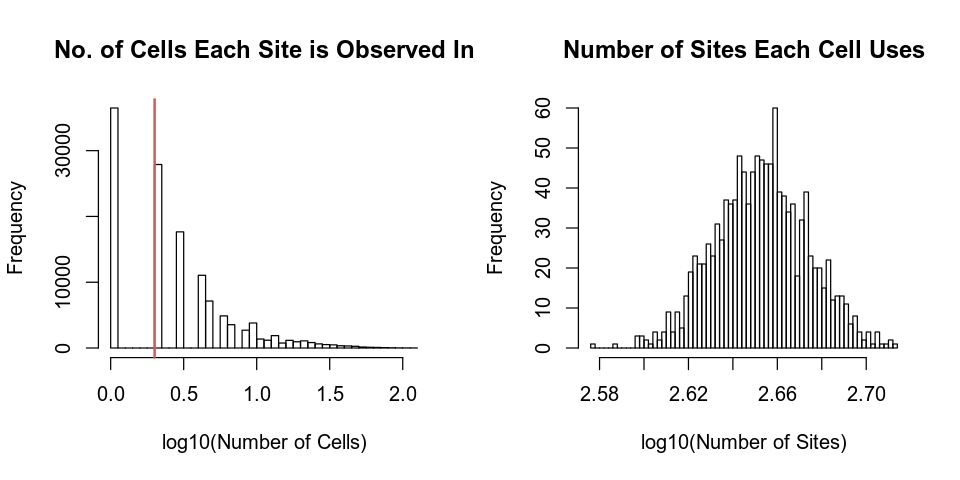

In [9]:
se <- select_peaks(se)

In [10]:
se

class: RangedSummarizedExperiment 
dim: 80000 1200 
metadata(0):
assays(1): counts
rownames(80000): chr1_9942_10442 chr1_12478_12978 ...
  chrX_154841997_154842497 chrX_154862080_154862580
rowData names(0):
colnames(1200): CD4_1 CD4_2 ... NK_1199 NK_1200
colData names(1): label

In [11]:
running_time <- c()

In [12]:
labels = se@colData$label
colormap = jdb_color_maps

#### Control-Naive

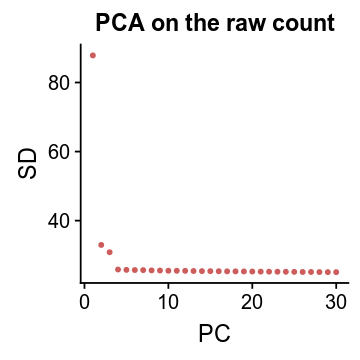

In [13]:
p_elbow_control <- elbow_plot(assays(se)$count,num_pcs = 30, title = 'PCA on the raw count')
p_elbow_control

In [14]:
run_control <- function(se,num_pcs=10){
    mat = as.matrix(assays(se)$count)
    fm_control = run_pca(mat,num_pcs = num_pcs)
    return(fm_control)
}

In [15]:
start_time <- Sys.time()

In [16]:
fm_control = run_control(se)

In [17]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, control=tol_time)

Time difference of 0.2002576 mins

In [18]:
df_umap_control <- run_umap(fm_control)

In [19]:
head(labels)

[1] "CD4" "CD4" "CD4" "CD4" "CD4" "CD4"

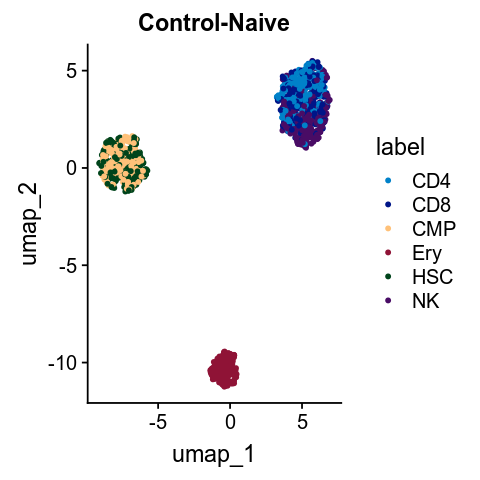

In [20]:
p_control <- plot_umap(df_umap_control,labels = labels,colormap = colormap,title='Control-Naive')
p_control

#### chromVAR

In [21]:
run_chromVAR <- function(se,feature='motif',genome='hg19'){
    chromvar_se = se
    register(MulticoreParam(10))
    set.seed(2019)
    if(genome == 'hg19'){
        genome_ref = BSgenome.Hsapiens.UCSC.hg19
    }else{
        stop(paste0(genome,' is not supported'))
    }
    chromvar_se <- addGCBias(chromvar_se, genome = genome_ref)
    bg <- getBackgroundPeaks(chromvar_se)
    if(feature=='motif'){
        motifs <- getJasparMotifs()
        motif_ix <- matchMotifs(motifs, chromvar_se, genome = genome_ref)     
        dev_motif <- computeDeviations(object = chromvar_se, annotations = motif_ix,
                                 background_peaks = bg)
        fm_chromvar_motif <- dev_motif@assays[[1]]
        fm_chromVAR = fm_chromvar_motif
    }else if(feature == 'kmer'){
        kmer_ix <- matchKmers(6, chromvar_se, genome_ref)
        dev_kmer <- computeDeviations(object = chromvar_se, annotations = kmer_ix,
                                 background_peaks = bg)
        fm_chromvar_kmer <- dev_kmer@assays[[1]]
        fm_chromVAR = fm_chromvar_kmer
    }else{
        stop(paste0(feature,' is not supported'))
    }
    return(fm_chromVAR)
}

In [22]:
start_time <- Sys.time()

In [23]:
fm_chromVAR_motif = run_chromVAR(se,feature='motif')

In [24]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, chromVAR_motif=tol_time)

Time difference of 1.450953 mins

In [25]:
start_time <- Sys.time()

In [26]:
fm_chromVAR_kmer = run_chromVAR(se,feature='kmer')

In [27]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, chromVAR_kmer=tol_time)

Time difference of 1.735271 mins

In [28]:
df_umap_chromVAR_motif <- run_umap(fm_chromVAR_motif)
df_umap_chromVAR_kmer <- run_umap(fm_chromVAR_kmer)

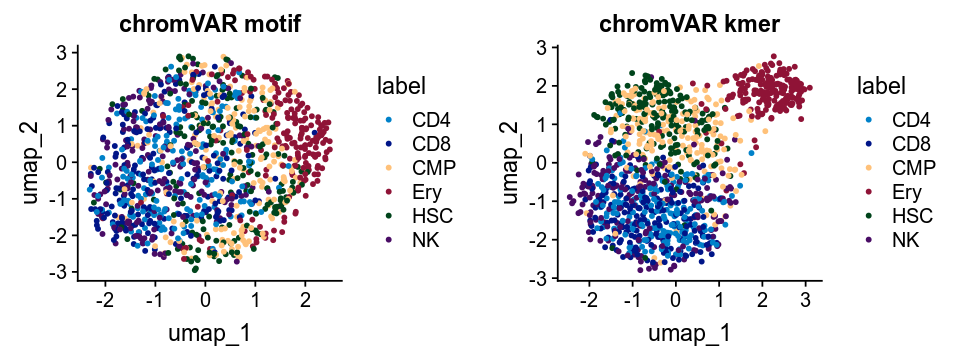

In [29]:
p_chromVAR_motif <- plot_umap(df_umap_chromVAR_motif,labels = labels,colormap = colormap,title='chromVAR motif')
p_chromVAR_kmer <- plot_umap(df_umap_chromVAR_kmer,labels = labels,colormap = colormap,title='chromVAR kmer')

options(repr.plot.width=8, repr.plot.height=3)
cowplot::plot_grid(p_chromVAR_motif,p_chromVAR_kmer)

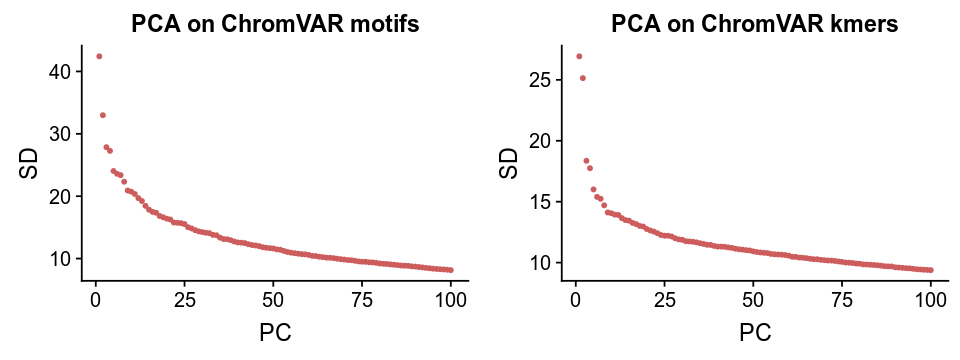

In [30]:
p_elbow_chromVAR_motif <- elbow_plot(fm_chromVAR_motif,num_pcs = 100, title = 'PCA on ChromVAR motifs')
p_elbow_chromVAR_kmer <- elbow_plot(fm_chromVAR_kmer,num_pcs = 100, title = 'PCA on ChromVAR kmers')

options(repr.plot.width=8, repr.plot.height=3)
cowplot::plot_grid(p_elbow_chromVAR_motif,p_elbow_chromVAR_kmer)

In [31]:
fm_chromVAR_motif2 = run_pca(fm_chromVAR_motif,num_pcs = 40)
fm_chromVAR_kmer2 = run_pca(fm_chromVAR_kmer,num_pcs = 40)

In [32]:
df_umap_chromVAR_motif2 <- run_umap(fm_chromVAR_motif2)
df_umap_chromVAR_kmer2 <- run_umap(fm_chromVAR_kmer2)

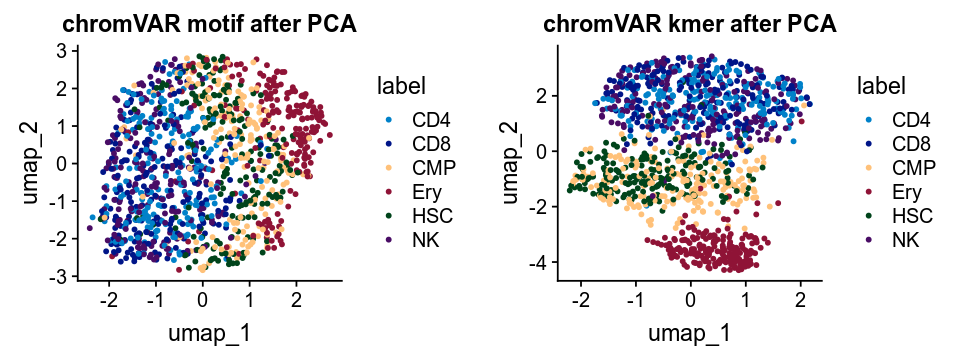

In [33]:
p_chromVAR_motif2 <- plot_umap(df_umap_chromVAR_motif2,labels = labels,colormap = colormap,title='chromVAR motif after PCA')
p_chromVAR_kmer2 <- plot_umap(df_umap_chromVAR_kmer2,labels = labels,colormap = colormap,title='chromVAR kmer after PCA')

options(repr.plot.width=8, repr.plot.height=3)
cowplot::plot_grid(p_chromVAR_motif2,p_chromVAR_kmer2)

### Cusanovich2018

In [34]:
run_Cusanovich2018_normalize <- function(se){
    binary_mat = as.matrix((assays(se)$counts > 0) + 0)
    binary_mat = Matrix(binary_mat, sparse = TRUE) 
    ncounts = binary_mat
    nfreqs = t(t(ncounts) / Matrix::colSums(ncounts))
    idf = as(log(1 + ncol(ncounts) / Matrix::rowSums(ncounts)), "sparseVector")
    tf_idf_counts = as(Diagonal(x=as.vector(idf)), "sparseMatrix") %*% nfreqs
    return(tf_idf_counts)
}
run_Cusanovich2018 <- function(mat_Cusanovich2018,num_pcs=10){
    fm_Cusanovich2018 = run_pca(mat_Cusanovich2018,num_pcs = num_pcs)
    return(fm_Cusanovich2018)
}

In [35]:
start_time <- Sys.time()

In [36]:
mat_Cusanovich2018 <- run_Cusanovich2018_normalize(se)
dim(mat_Cusanovich2018)

[1] 80000  1200

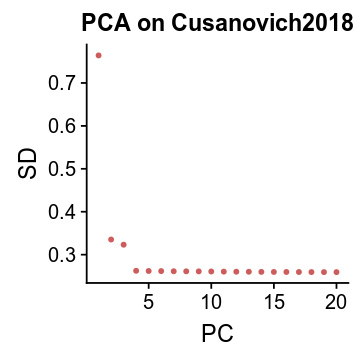

In [37]:
p_elbow_Cusanovich2018 <- elbow_plot(mat_Cusanovich2018,num_pcs = 20, title = 'PCA on Cusanovich2018')
p_elbow_Cusanovich2018

In [38]:
fm_Cusanovich2018 = run_Cusanovich2018(mat_Cusanovich2018,num_pcs=10)

In [39]:
df_umap_Cusanovich2018 <- run_umap(fm_Cusanovich2018)

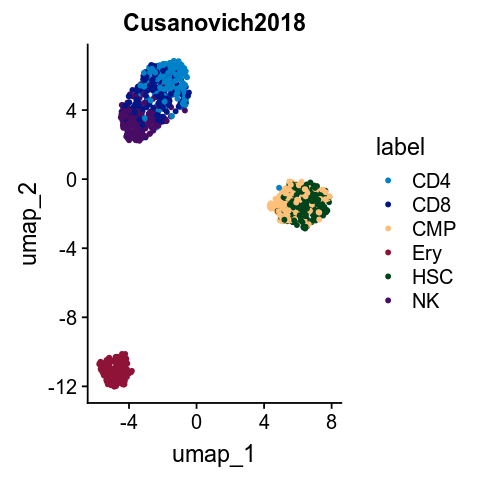

In [40]:
p_Cusanovich2018 <- plot_umap(df_umap_Cusanovich2018,labels = labels,colormap = colormap,title='Cusanovich2018')
p_Cusanovich2018

In [41]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, Cusanovich2018=tol_time)

Time difference of 0.6232157 mins

### cisTopic

In [42]:
run_cisTopic <- function(se){ 
    set.seed(2019)
    cistopics_counts = assays(se)$counts
    rownames(cistopics_counts) = lapply(strsplit(rownames(se),'_'),FUN=function(x){paste(paste(x[1],x[2],sep=":"),x[3],sep='-')})
    cisTopicObject <- createcisTopicObject(cistopics_counts, project.name='cisTopic')
    cisTopicObject <- runModels(cisTopicObject, topic=c(2, 5:15, 20, 25), 
                                seed=2019, nCores=10, burnin = 120, iterations = 150, addModels=FALSE)    
    cisTopicObject <- selectModel(cisTopicObject)
    fm_cisTopic <- modelMatSelection(cisTopicObject, 'cell', 'Probability')
    return(fm_cisTopic)
}

In [43]:
start_time <- Sys.time()

[1] "Formatting data..."
[1] "Exporting data..."
[1] "Running models..."


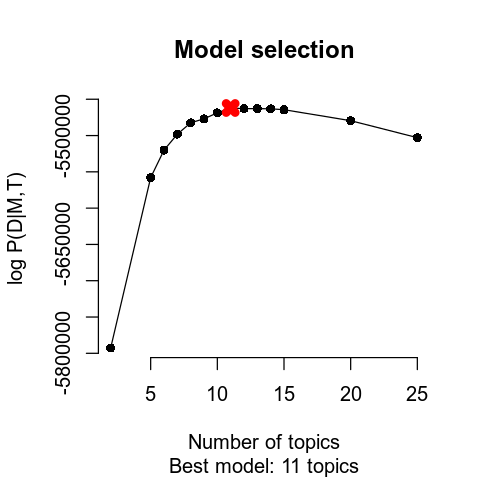

In [44]:
fm_cisTopic <- run_cisTopic(se)

In [45]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, Cistopic=tol_time)

Time difference of 4.420577 mins

In [46]:
df_umap_cisTopic <- run_umap(fm_cisTopic)

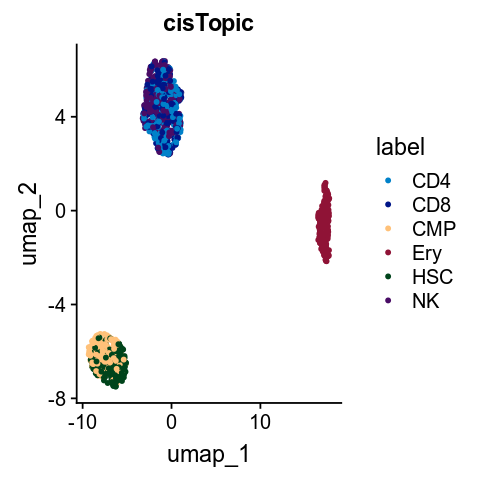

In [47]:
p_cisTopic <- plot_umap(df_umap_cisTopic,labels = labels,colormap = colormap,title='cisTopic')
p_cisTopic

### Gene Scoring

In [48]:
run_GeneScoring <- function(se,file_tss){
    # Import gene bodies; restrict to TSS
    gdf <- read.table(file_tss, stringsAsFactors = FALSE)
    tss <- data.frame(chr = gdf$V1, gene = gdf$V4, stringsAsFactors = FALSE)
    tss$tss <-  ifelse(gdf$V5 == "+", gdf$V3, gdf$V2)
    tss$start <- ifelse(tss$tss - 50000 > 0, tss$tss - 50000, 0)
    tss$stop <- tss$tss + 50000
    tss_idx <- makeGRangesFromDataFrame(tss, keep.extra.columns = TRUE)
    # Import ATAC peaks
    adf <- data.frame(chrom=seqnames(rowRanges(se)),start=start(rowRanges(se)),end=end(rowRanges(se)))
    adf$mp <- (adf$start + adf$end)/2
    atacgranges <- makeGRangesFromDataFrame(adf, start.field = "mp", end.field = "mp")    
    #Overlap between ATAC peaks and Ranges linker
    ov <- findOverlaps(atacgranges, tss_idx)
    # Make a plot
    qplot(table(subjectHits(ov)), binwidth = 1) + theme(plot.subtitle = element_text(vjust = 1), 
                                                              plot.caption = element_text(vjust = 1)) +
      labs(title = "Histogram of peaks per gene",  x = "Peaks / gene") + pretty_plot()    
    # Do distance decay for the weights
    dist <- abs(mcols(tss_idx)$tss[subjectHits(ov)] - start(atacgranges)[queryHits(ov)])
    exp_dist_model <- exp(-1*dist/5000)
    # Prep an outcome matrix
    m <- Matrix::sparseMatrix(i = c(queryHits(ov), length(atacgranges)),
                              j = c(subjectHits(ov), length(tss_idx)),
                              x = c(exp_dist_model,0))
    colnames(m) <- gdf$V4
    m <- m[,which(Matrix::colSums(m) != 0)]
    fm_genescoring <- data.matrix(t(m) %*% assays(se)$counts)
    return(fm_genescoring)
}

In [49]:
start_time <- Sys.time()

In [50]:
fm_GeneScoring <- run_GeneScoring(se,file_tss='../input/hg19/hg19-tss.bed')

In [51]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, GeneScoring=tol_time)

Time difference of 0.01932361 mins

In [52]:
df_umap_GeneScoring <- run_umap(fm_GeneScoring)

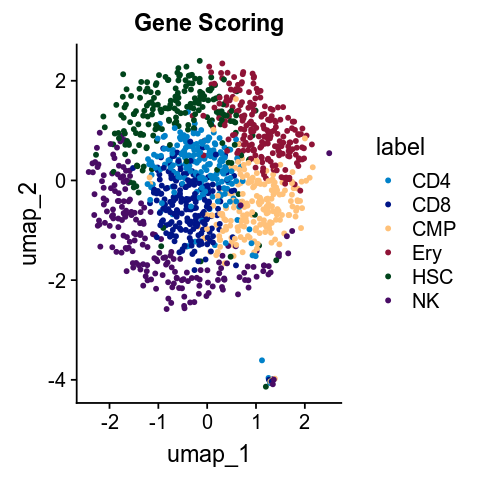

In [53]:
p_GeneScoring <- plot_umap(df_umap_GeneScoring,labels = labels,colormap = colormap,title='Gene Scoring')
p_GeneScoring

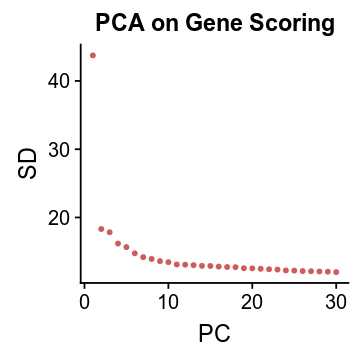

In [54]:
p_elbow_GeneScoring <- elbow_plot(fm_GeneScoring,num_pcs = 30, title = 'PCA on Gene Scoring')
p_elbow_GeneScoring

In [55]:
fm_GeneScoring2 = run_pca(fm_GeneScoring,num_pcs = 10)

In [56]:
df_umap_GeneScoring2 <- run_umap(fm_GeneScoring2)

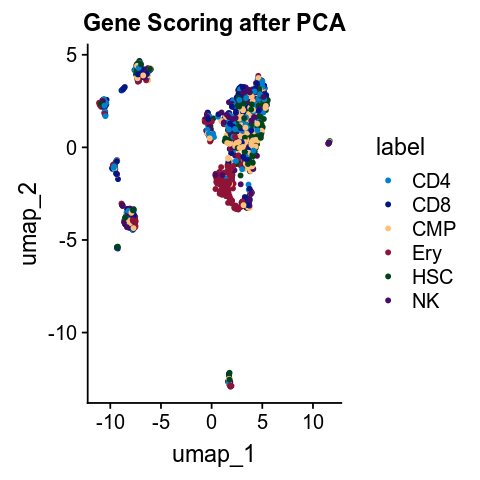

In [57]:
p_GeneScoring2 <- plot_umap(df_umap_GeneScoring2,labels = labels,colormap = colormap,title='Gene Scoring after PCA')
p_GeneScoring2

### Cicero

In [58]:
run_Cicero <- function(se,genome,file_tss){
    if(genome == 'hg19'){
        data("human.hg19.genome")
        genome_ref = human.hg19.genome
    }else{
        stop(paste0(genome,' is not supported'))
    }
    fData <- data.frame(chromosome=seqnames(rowRanges(se)),bp1=start(rowRanges(se)),bp2=end(rowRanges(se)),
                       stringsAsFactors = FALSE)
    peaknames = paste(fData$chromosome,fData$bp1,fData$bp2,sep = "_")
    rownames(fData)<- peaknames
    fData <- cbind(site_name = peaknames, fData)   
    pData <- data.frame(label=colData(se)$label,stringsAsFactors = FALSE)
    rownames(pData) = colnames(se)    
    pd <- new("AnnotatedDataFrame", data = pData)
    fd <- new("AnnotatedDataFrame", data = fData)  
    binary_mat = as.matrix((assays(se)$counts > 0) + 0)
    binary_mat = Matrix(binary_mat, sparse = TRUE) 
    input_cds <- newCellDataSet(binary_mat,phenoData = pd, featureData = fd,
                                expressionFamily=VGAM::binomialff(),
                                lowerDetectionLimit=0)
    input_cds@expressionFamily@vfamily <- "binomialff"
    set.seed(2019)
    input_cds <- detectGenes(input_cds)
    input_cds <- estimateSizeFactors(input_cds)
    input_cds <- reduceDimension(input_cds, max_components = 2, num_dim=15,
                            reduction_method = 'tSNE', norm_method = "none")    
    tsne_coords <- t(reducedDimA(input_cds))
    row.names(tsne_coords) <- row.names(pData(input_cds))
    cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = tsne_coords)
    conns <- run_cicero(cicero_cds, genome_ref) # Takes a few minutes to run
    
    gene_annotation <- read.table(file_tss,sep='\t')
    names(gene_annotation)[4] <- "gene"    
    gene_annotation_pos <- subset(gene_annotation, V5 == "+")
    gene_annotation_neg <- subset(gene_annotation, V5 == "-")
    gene_annotation_pos$V3 <- gene_annotation_pos$V2 + 1
    gene_annotation_neg$V2 <- gene_annotation_neg$V3 - 1
    tss <- rbind(gene_annotation_pos, gene_annotation_neg)    
    
    input_cds <- annotate_cds_by_site(input_cds, tss)
    # generate unnormalized gene activity matrix
    unnorm_ga <- build_gene_activity_matrix(input_cds, conns)
    unnorm_ga <- unnorm_ga[!Matrix::rowSums(unnorm_ga) == 0,]

    # make a list of num_genes_expressed
    num_genes <- pData(input_cds)$num_genes_expressed
    names(num_genes) <- row.names(pData(input_cds))

    # normalize
    cicero_gene_activities <- normalize_gene_activities(unnorm_ga, num_genes)    
    fm_Cicero = as.matrix(cicero_gene_activities)
    return(fm_Cicero)
}

In [59]:
start_time <- Sys.time()

In [60]:
fm_Cicero <- run_Cicero(se,genome='hg19',file_tss='../input/hg19/hg19-tss.bed')

Warning message in newCellDataSet(binary_mat, phenoData = pd, featureData = fd, :
"Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions"Warning message in newCellDataSet(binary_mat, phenoData = pd, featureData = fd, :
"Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions"Warning message in newCellDataSet(binary_mat, phenoData = pd, featureData = fd, :
"Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions"Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 2.28918461694381
Median shared cells bin-bin: 0


[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Done"


In [61]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, Cicero=tol_time)

Time difference of 8.766044 mins

In [62]:
df_umap_Cicero <- run_umap(fm_Cicero)

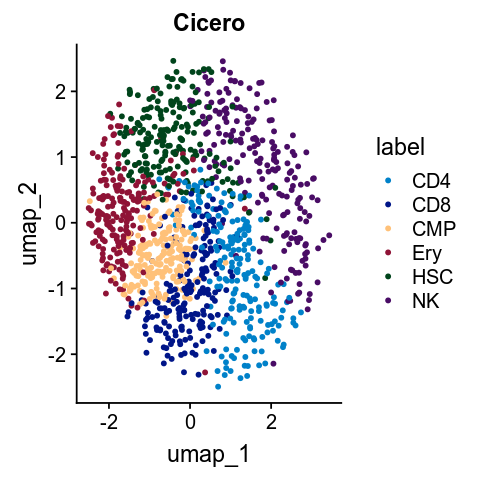

In [63]:
p_Cicero <- plot_umap(df_umap_Cicero,labels = labels,colormap = colormap,title='Cicero')
p_Cicero

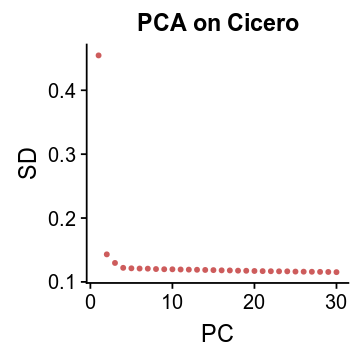

In [64]:
p_elbow_Cicero <- elbow_plot(fm_Cicero,num_pcs = 30, title = 'PCA on Cicero')
p_elbow_Cicero

In [65]:
fm_Cicero2 = run_pca(fm_Cicero,num_pcs = 10)

In [66]:
df_umap_Cicero2 <- run_umap(fm_Cicero2)

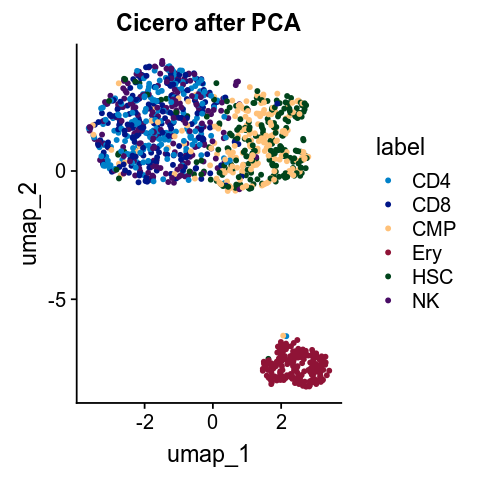

In [67]:
p_Cicero2 <- plot_umap(df_umap_Cicero2,labels = labels,colormap = colormap,title='Cicero after PCA')
p_Cicero2

### SnapATAC

In [68]:
calJaccard <- function(X_i, X_j){
    A = Matrix::tcrossprod(X_i, X_j);
    bi = Matrix::rowSums(X_i);
    bj = Matrix::rowSums(X_j);
    jmat = as.matrix(A / (replicate(ncol(A), bi) + t(replicate(nrow(A), bj)) - A));
    return(jmat);}
normJaccard <- function(jmat, b1, b2, method, k=15){
    # estimate the expected jaccard index using OVN
    #' @importFrom raster focal raster
    .normOVN <- function(o, p1, p2, k){
        # sort the jaccard index matrix based on the coverage
        ind1 = order(p1);
        ind2 = order(p2);
        o_srt = as.matrix(o[ind1, ind2, drop=FALSE]);
        # calculate expected jaccard index
        mask_mat <- matrix(1, k, k);
        exp = focal(raster(as.matrix(o_srt)), mask_mat, mean, na.rm=TRUE, pad = T);
        ee = raster::as.matrix(exp)[order(ind1),order(ind2),drop=FALSE];
        return(ee)
    }

    # estimate the expected jaccard index using OVE
    .normOVE <- function(o, p1, p2, k){
        pp = tcrossprod(p1, p2);
        ss = matrix(rep(p1,each=length(p2)), ncol=length(p2), byrow=TRUE) +  matrix(rep(p2, each=length(p1)), ncol=length(p2), byrow=FALSE)
        ee = pp/(ss - pp)
        return(ee)
    }

    jmat[jmat == 1] = mean(jmat);
    x = jmat;
    emat = eval(parse( text = paste(".", method, "(x, b1, b2, k)", sep="")));				
    if(method == "normOVE"){
        data = data.frame(x=c(emat), y=c(jmat))	
        model = stats::lm(y ~ x, data)
        nmat = matrix(model$residuals, nrow(emat), ncol(emat));
    }else if(method == "normOVN"){
        nmat = jmat - emat;
    }
    rm(jmat)
    rm(emat)
    return(nmat);
}

In [69]:
run_SnapATAC_normalize <- function(se){
    binary_mat = as.matrix((assays(se)$counts > 0) + 0)
    binary_mat = Matrix(binary_mat, sparse = TRUE) 
    mat.use = t(binary_mat)
    # max.var = min(1000, nrow(mat.use));
    set.seed(2019)
    # mat.ref = mat.use[sort(sample(seq(nrow(mat.use)), max.var)),]
    mat.ref = mat.use
    jmat = calJaccard(mat.use, mat.ref)
    p1<- Matrix::rowMeans(mat.use);
    p2<- Matrix::rowMeans(mat.ref);
    nmat <- normJaccard(jmat=jmat, b1=p1, b2=p2, method = 'normOVE', k=15);
    args <- list(A=nmat, nv=50)
    args$center <- colMeans(nmat)
    x.norm = sweep(args$A, 2, args$center, FUN=`-`)
    return(x.norm)
}
run_SnapATAC <- function(mat_SnapATAC,num_pcs=10){
    fm_SnapATAC = run_pca(mat_SnapATAC,num_pcs = num_pcs)
    return(fm_SnapATAC)
}

In [70]:
start_time <- Sys.time()

In [71]:
mat_SnapATAC <- run_SnapATAC_normalize(se)
dim(mat_SnapATAC)

[1] 1200 1200

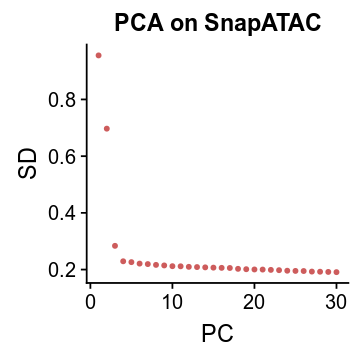

In [72]:
p_elbow_SnapATAC <- elbow_plot(mat_SnapATAC,num_pcs = 30, title = 'PCA on SnapATAC')
p_elbow_SnapATAC

In [73]:
fm_SnapATAC = run_SnapATAC(mat_SnapATAC,num_pcs=10)

In [74]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, SnapATAC=tol_time)

Time difference of 0.04437993 mins

In [75]:
df_umap_SnapATAC <- run_umap(fm_SnapATAC)

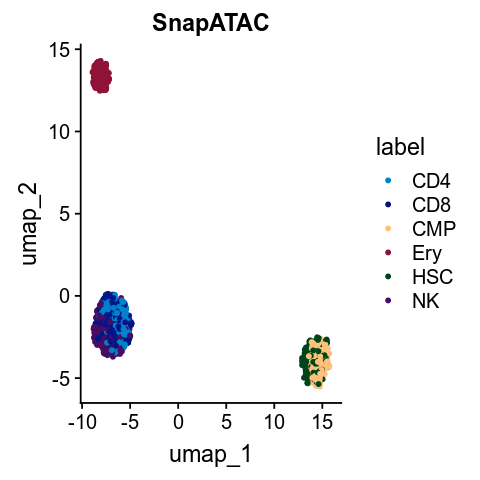

In [76]:
p_SnapATAC <- plot_umap(df_umap_SnapATAC,labels = labels,colormap = colormap,title='SnapATAC')
p_SnapATAC

### scABC

In [77]:
sort_peaks <- function(peaks){
  return(peaks[order(peaks$chrom, peaks$start), ])
}
peaks2GRanges <- function(peaks, upstream = 0, downstream = 0){
  peaks.gr = with(peaks, GenomicRanges::GRanges(chrom, IRanges::IRanges(sapply(start, function(x) max(0, x - upstream)), end + downstream)))
}

In [78]:
run_scABC <- function(se){
    
    fm_scABC = as.matrix(assays(se)$counts)

############################################################################################################  
# The following code is used to calculate the weigths of cells in scABC. Since in scABC 
# the weights are not used to normalize the raw count matrix, instead it's used for k-medoid clustering 
# (the feature matrix used is the peaks by cells raw count matrix), 
# here for scABC, we consider the running time as the time used for computing weights     
############################################################################################################     
    
    se_scABC = se
    df_peaks <- data.frame(chrom=seqnames(rowRanges(se_scABC)),
      start=start(rowRanges(se_scABC))-1,
      end=end(rowRanges(se_scABC)))
    df_peaks = sort_peaks(df_peaks)
    background_peaks.gr = peaks2GRanges(df_peaks, upstream=500000, downstream=500000)
    foreground_peaks.gr = rowRanges(se_scABC)    
    fg_mat = assays(se_scABC)$counts
    ov_peaks = findOverlaps(background_peaks.gr, foreground_peaks.gr)
    m <- Matrix::sparseMatrix(i = c(queryHits(ov_peaks), length(background_peaks.gr)),
                              j = c(subjectHits(ov_peaks), length(foreground_peaks.gr)))
    bg_mat = m %*% fg_mat  
    weights = apply(bg_mat, 2, mean);
    c = min(8, mean(weights))
    # compute weighted k-medioids
    lambda = 0.1
    weights = 1/(1 + exp(-(weights - c)/(c*lambda)));
    return(fm_scABC)
}

In [79]:
start_time <- Sys.time()

In [80]:
fm_scABC = run_scABC(se)

In [81]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, scABC=tol_time)

Time difference of 0.1181031 mins

In [82]:
df_umap_scABC <- run_umap(fm_scABC)

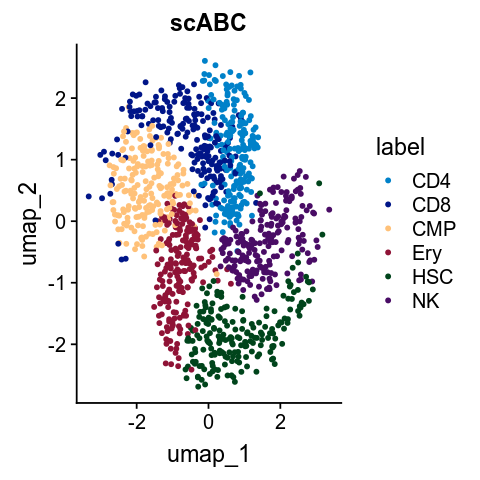

In [83]:
p_scABC <- plot_umap(df_umap_scABC,labels = labels,colormap = colormap,title='scABC')
p_scABC

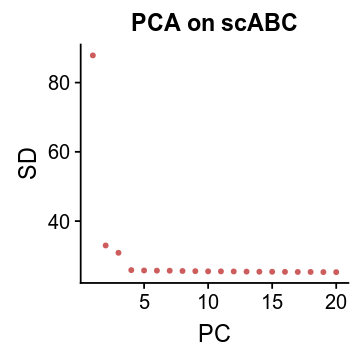

In [84]:
p_elbow_scABC <- elbow_plot(fm_scABC,num_pcs = 20, title = 'PCA on scABC')
p_elbow_scABC

In [85]:
fm_scABC2 = run_pca(fm_scABC,num_pcs = 10)

In [86]:
df_umap_scABC2 <- run_umap(fm_scABC2)

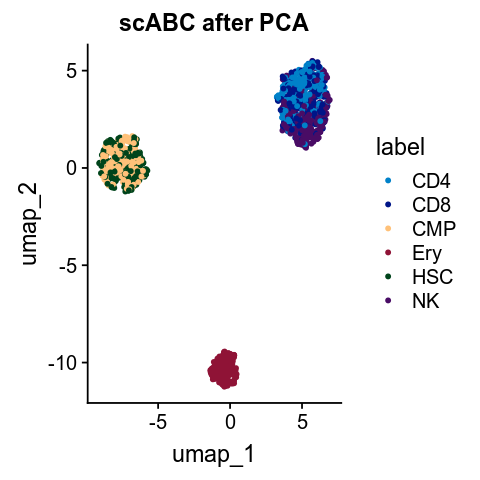

In [87]:
p_scABC2 <- plot_umap(df_umap_scABC2,labels = labels,colormap = colormap,title='scABC after PCA')
p_scABC2

### SCRAT

In [88]:
run_SCRAT <- function(se,genome='hg19',adjustlen = TRUE, log2transform = TRUE){
    genome = 'hg19'
    Motifflank = 100
    allres <- NULL
    scrat_counts = assays(se)$counts
    gr_peaks <- rowRanges(se)
    datapath <- system.file("extdata", package = paste0("SCRATdata", 
        genome))
    print("Processing MOTIF_JASPAR features")
    
    load(paste0(datapath, "/gr/jaspar1.rda"))
    gr <- flank(gr, as.numeric(Motifflank), both = T)
    # tmp <- sapply(bamdata, function(i) countOverlaps(gr, 
    #     i))
    # tmp <- sweep(tmp, 2, bamsummary, "/") * 10000
    ov_peaks = findOverlaps(gr, gr_peaks)
    m <- Matrix::sparseMatrix(i = c(queryHits(ov_peaks), length(gr)),
                              j = c(subjectHits(ov_peaks), length(gr_peaks)))
    mat_motif = m %*% scrat_counts 
    tmp <- sweep(mat_motif, 2, Matrix::colSums(scrat_counts), "/") * 10000

    if (log2transform) {
        tmp <- log2(tmp + 1)
    }
    if (adjustlen) {
        grrange <- sapply(gr, function(i) sum(end(i) - start(i) + 
            1))
        tmp <- sweep(tmp, 1, grrange, "/") * 1e+06
    }
    tmp <- tmp[Matrix::rowSums(tmp) > 0, , drop = F]
    allres <- rbind(allres, tmp)

    load(paste0(datapath, "/gr/jaspar2.rda"))
    gr <- flank(gr, as.numeric(Motifflank), both = T)
    # tmp <- sapply(bamdata, function(i) countOverlaps(gr, 
    #     i))
    # tmp <- sweep(tmp, 2, bamsummary, "/") * 10000

    ov_peaks = findOverlaps(gr, gr_peaks)
    m <- Matrix::sparseMatrix(i = c(queryHits(ov_peaks), length(gr)),
                              j = c(subjectHits(ov_peaks), length(gr_peaks)))
    mat_motif = m %*% scrat_counts 

    tmp <- sweep(mat_motif, 2, Matrix::colSums(scrat_counts), "/") * 10000
    if (log2transform) {
        tmp <- log2(tmp + 1)
    }
    if (adjustlen) {
        grrange <- sapply(gr, function(i) sum(end(i) - start(i) + 
            1))
        tmp <- sweep(tmp, 1, grrange, "/") * 1e+06
    }
    tmp <- tmp[Matrix::rowSums(tmp) > 0, , drop = F]
    allres <- rbind(allres, tmp)     
    fm_SCRAT = as.matrix(allres)
    return(fm_SCRAT)
}

In [89]:
start_time <- Sys.time()

In [90]:
fm_SCRAT = run_SCRAT(se,adjustlen = FALSE, log2transform = FALSE)

[1] "Processing MOTIF_JASPAR features"


In [91]:
dim(fm_SCRAT)

[1]  519 1200

In [92]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, SCRAT=tol_time)

Time difference of 0.6181271 mins

In [93]:
df_umap_SCRAT <- run_umap(fm_SCRAT)

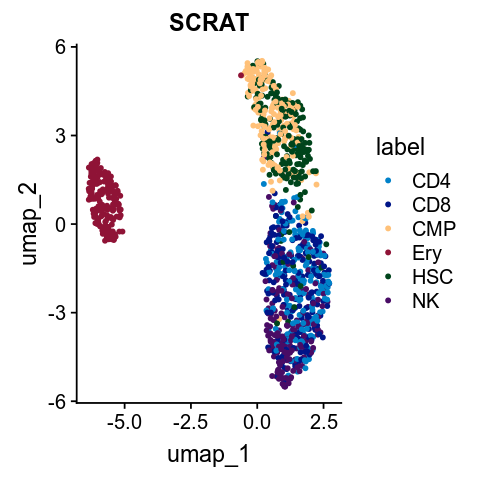

In [94]:
p_SCRAT <- plot_umap(df_umap_SCRAT,labels = labels,colormap = colormap,title='SCRAT')
p_SCRAT

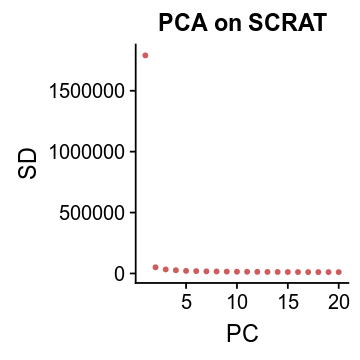

In [95]:
p_elbow_SCRAT <- elbow_plot(fm_SCRAT,num_pcs = 20, title = 'PCA on SCRAT')
p_elbow_SCRAT

In [96]:
fm_SCRAT2 = run_pca(fm_SCRAT,num_pcs = 10)

In [97]:
df_umap_SCRAT2 <- run_umap(fm_SCRAT2)

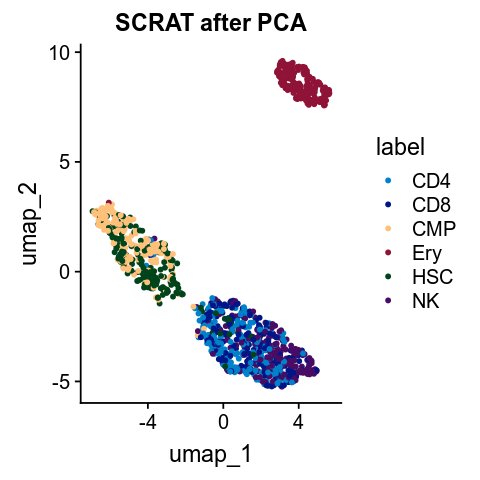

In [98]:
p_SCRAT2 <- plot_umap(df_umap_SCRAT2,labels = labels,colormap = colormap,title='SCRAT after PCA')
p_SCRAT2

### Scasat

In [99]:
run_Scasat <- function(se){
    binary_mat = as.matrix((assays(se)$counts > 0) + 0)
    binary_mat = Matrix(binary_mat, sparse = TRUE) 
    SingleCell.Binary.Jaccard <- jaccard(as.matrix(binary_mat))
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=10)
    fm_Scasat = t(fit$points)
    return(fm_Scasat)
}

In [100]:
start_time <- Sys.time()

In [101]:
fm_Scasat <- run_Scasat(se)

In [102]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, Scasat=tol_time)

Time difference of 0.1058036 mins

In [103]:
df_umap_Scasat <- run_umap(fm_Scasat)

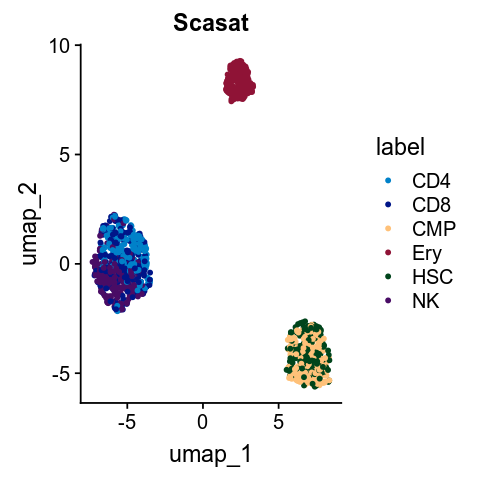

In [104]:
p_Scasat <- plot_umap(df_umap_Scasat,labels = labels,colormap = colormap,title='Scasat')
p_Scasat

### BROCKMAN

In [105]:
run_BROCKMAN_preprocess <- function(se,file_path){
    peaks = rowRanges(se)
    binary_mat = as.matrix((assays(se)$counts > 0) + 0)
    binary_mat = Matrix(binary_mat, sparse = TRUE)
    for (i in 1:ncol(binary_mat)){
        peaks_i = peaks[which(binary_mat[,i]!=0,arr.ind = T)]
        df_bed_i <- data.frame(chrom=seqnames(peaks_i),start=start(peaks_i)-1,end=end(peaks_i))
        system(paste0('mkdir -p ',file_path,'bed'))
        write.table(df_bed_i, file=paste0(file_path,'bed/', colnames(se)[i],'.bed'), quote=F, sep="\t", row.names=F, col.names=F)
    }    
}

run_BROCKMAN_normalize <- function(se,file_path){
    sampleDesc = colData(se)
    fileNames = fileNames = sprintf(paste0(file_path,"kmers/%s.freq.gz"),rownames(sampleDesc))
    IDs = rownames(sampleDesc)
    stopifnot(length(fileNames) == length(IDs))
    curData = read.table(fileNames[1], sep = "\t", header = T, 
        stringsAsFactors = FALSE, quote = "", row.names = NULL)
    allData = matrix(nrow = nrow(curData), ncol = nrow(sampleDesc))
    row.names(allData) = curData$kMer
    colnames(allData) = IDs
    for (i in 1:length(fileNames)) {
        if (i%%50 == 1) {
            message(sprintf("Inputting i=%i/%i", i, length(fileNames)))
        }
        curData = read.table(fileNames[i], sep = "\t", header = T, 
            stringsAsFactors = FALSE, quote = "", row.names = NULL)
        allData[, i] = curData$Pct_FG
    }   
#     allData = BrockmanR::inputKMerFreqs(fileNames = sprintf(paste0(file_path,"kmers/%s.freq.gz"),rownames(sampleDesc)), 
#                                         IDs = rownames(sampleDesc))   
#     bugs: Error in nrow(sampleDesc): object 'sampleDesc' not found
    return(allData)
}

run_BROCKMAN <- function(mat_BROCKMAN,num_pcs=10){
    pcs = doKMerPCA(mat_BROCKMAN, nPCs = num_pcs);
    fm_BROCKMAN = t(pcs$x)[1:pcs$nPCs,]
    return(fm_BROCKMAN)
}

In [106]:
path_brockman = './BROCKMAN_preprocess/'
# run_BROCKMAN_preprocess(se,file_path = path_brockman)

`bsub < get_gapped_kmers.sh`

In [109]:
start_time <- Sys.time()

In [110]:
mat_BROCKMAN <- run_BROCKMAN_normalize(se,file_path = path_brockman)

Inputting i=1/1200
Inputting i=51/1200
Inputting i=101/1200
Inputting i=151/1200
Inputting i=201/1200
Inputting i=251/1200
Inputting i=301/1200
Inputting i=351/1200
Inputting i=401/1200
Inputting i=451/1200
Inputting i=501/1200
Inputting i=551/1200
Inputting i=601/1200
Inputting i=651/1200
Inputting i=701/1200
Inputting i=751/1200
Inputting i=801/1200
Inputting i=851/1200
Inputting i=901/1200
Inputting i=951/1200
Inputting i=1001/1200
Inputting i=1051/1200
Inputting i=1101/1200
Inputting i=1151/1200


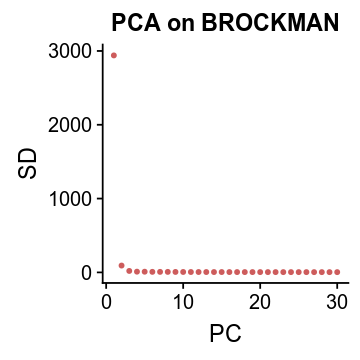

In [111]:
p_elbow_BROCKMAN <- elbow_plot(mat_BROCKMAN,num_pcs = 30, title = 'PCA on BROCKMAN')
p_elbow_BROCKMAN

In [112]:
fm_BROCKMAN = run_BROCKMAN(mat_BROCKMAN,num_pcs=10)

Scaling data
Doing PCA
Using 10 PCs
Doing tSNE
sigma summary: Min. : 0.344487041236909 |1st Qu. : 0.466972760459248 |Median : 0.495761549189111 |Mean : 0.497850467899961 |3rd Qu. : 0.526971313851338 |Max. : 0.656264651708163 |
Epoch: Iteration #100 error is: 17.4435874687294
Epoch: Iteration #200 error is: 1.55575380293861
Epoch: Iteration #300 error is: 1.44060027346031
Epoch: Iteration #400 error is: 1.40154597020713
Epoch: Iteration #500 error is: 1.38997928660108
Epoch: Iteration #600 error is: 1.38490632613578
Epoch: Iteration #700 error is: 1.38206232884145
Epoch: Iteration #800 error is: 1.38035541061355
Epoch: Iteration #900 error is: 1.37919995006302
Epoch: Iteration #1000 error is: 1.37836030089097


In [113]:
end_time <- Sys.time()
tol_time <- difftime(end_time, start_time, units = "mins")
tol_time
running_time <- c(running_time, BROCKMAN=tol_time)

Time difference of 11.21399 mins

In [114]:
df_umap_BROCKMAN <- run_umap(fm_BROCKMAN)

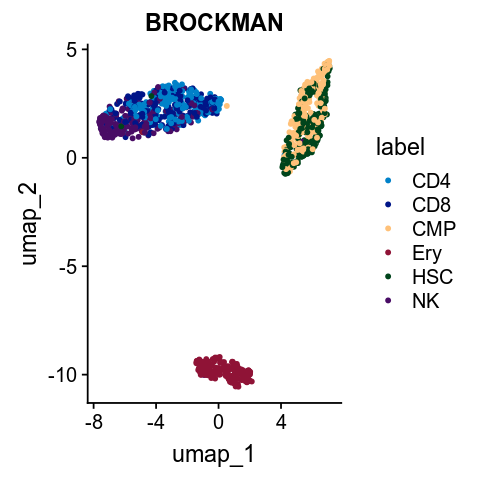

In [115]:
p_BROCKMAN <- plot_umap(df_umap_BROCKMAN,labels = labels,colormap = colormap,title='BROCKMAN')
p_BROCKMAN

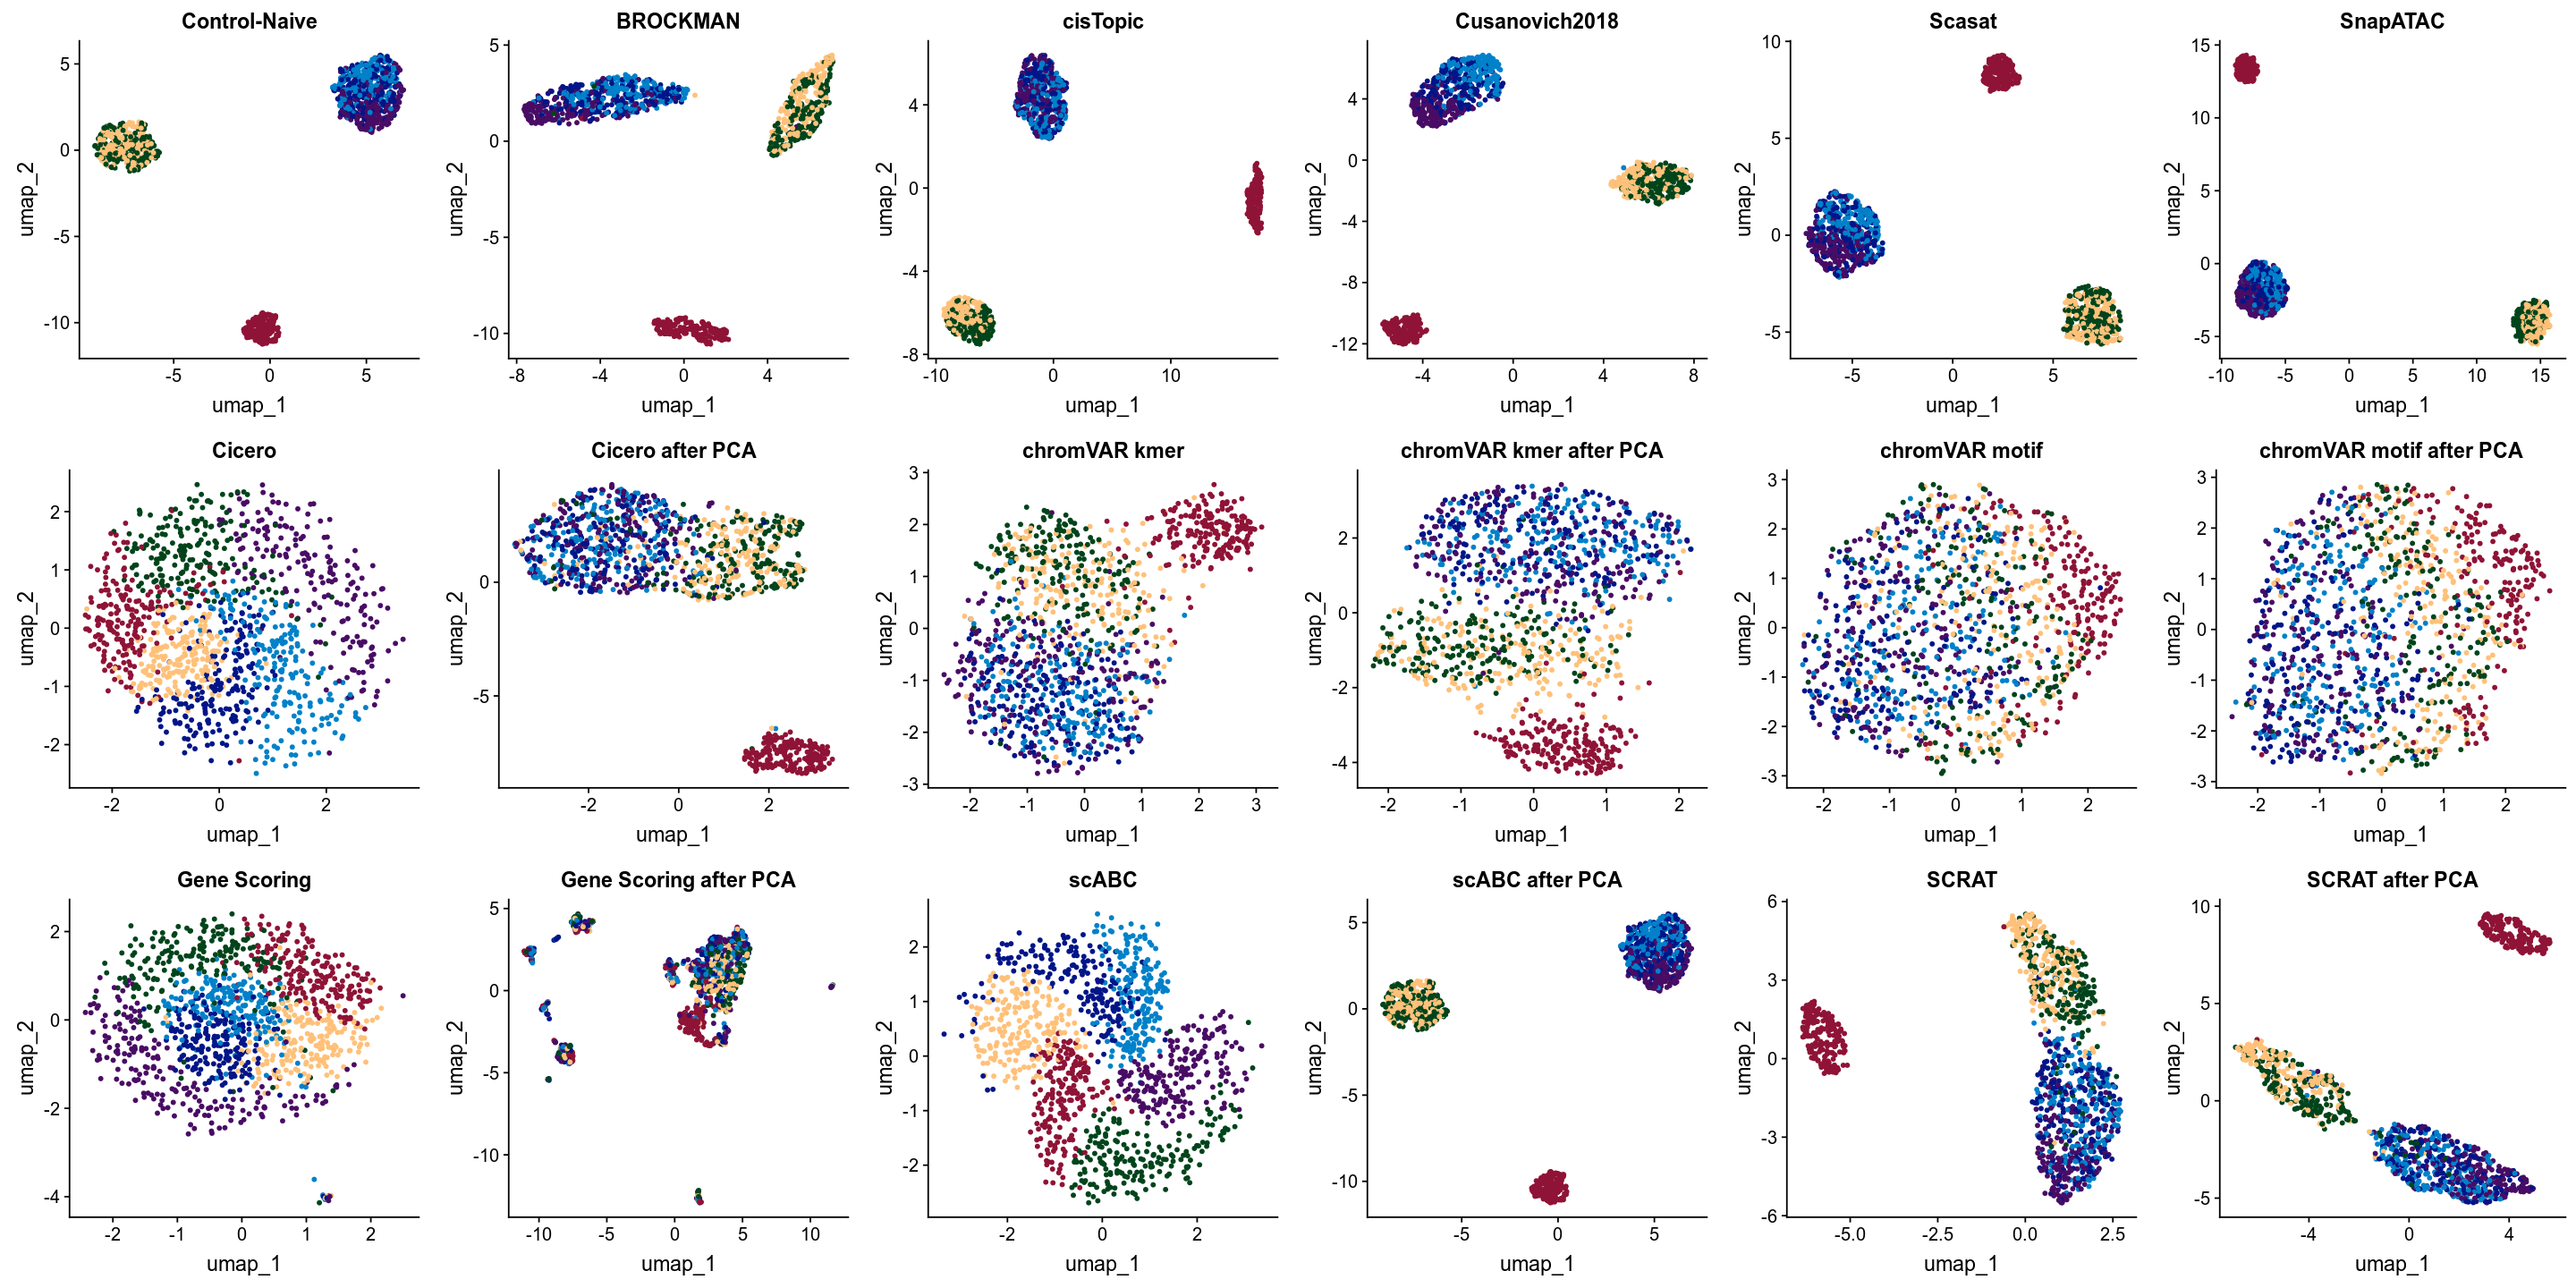

In [116]:
options(repr.plot.width=4*6, repr.plot.height=4*3)
cowplot::plot_grid(p_control+theme(legend.position = "none"),
                   p_BROCKMAN+theme(legend.position = "none"),
                   p_cisTopic+theme(legend.position = "none"),
                   p_Cusanovich2018+theme(legend.position = "none"),
                   p_Scasat+theme(legend.position = "none"),  
                   p_SnapATAC+theme(legend.position = "none"),         
                   p_Cicero+theme(legend.position = "none"),p_Cicero2+theme(legend.position = "none"),
                   p_chromVAR_kmer+theme(legend.position = "none"),p_chromVAR_kmer2+theme(legend.position = "none"),
                   p_chromVAR_motif+theme(legend.position = "none"),p_chromVAR_motif2+theme(legend.position = "none"),
                   p_GeneScoring+theme(legend.position = "none"),p_GeneScoring2+theme(legend.position = "none"),
                   p_scABC+theme(legend.position = "none"),p_scABC2+theme(legend.position = "none"),
                   p_SCRAT+theme(legend.position = "none"),p_SCRAT2+theme(legend.position = "none"),
                   labels = "",ncol = 6)

#### Save feature matrices and UMAP coordinates

In [117]:
dataset = 'BMcov500'

In [118]:
saveRDS(fm_control, file = paste0(path_fm,'FM_Control_',dataset,'.rds'))
saveRDS(fm_BROCKMAN, file = paste0(path_fm,'FM_BROCKMAN_',dataset,'.rds'))
saveRDS(fm_Cusanovich2018, file = paste0(path_fm,'FM_Cusanovich2018_',dataset,'.rds'))
saveRDS(fm_cisTopic, file = paste0(path_fm,'FM_cisTopic_',dataset,'.rds'))
saveRDS(fm_chromVAR_kmer, file = paste0(path_fm,'FM_chromVAR_',dataset,'_kmers.rds'))
saveRDS(fm_chromVAR_motif, file = paste0(path_fm,'FM_chromVAR_',dataset,'_motifs.rds'))
saveRDS(fm_chromVAR_kmer2, file = paste0(path_fm,'FM_chromVAR_',dataset,'_kmers_pca.rds'))
saveRDS(fm_chromVAR_motif2, file = paste0(path_fm,'FM_chromVAR_',dataset,'_motifs_pca.rds'))
saveRDS(fm_GeneScoring, file = paste0(path_fm,'FM_GeneScoring_',dataset,'.rds'))
saveRDS(fm_GeneScoring2, file = paste0(path_fm,'FM_GeneScoring_',dataset,'_pca.rds'))
saveRDS(fm_Cicero, file = paste0(path_fm,'FM_Cicero_',dataset,'.rds'))
saveRDS(fm_Cicero2, file = paste0(path_fm,'FM_Cicero_',dataset,'_pca.rds'))
saveRDS(fm_SnapATAC, file = paste0(path_fm,'FM_SnapATAC_',dataset,'.rds'))
saveRDS(fm_Scasat, file = paste0(path_fm,'FM_Scasat_',dataset,'.rds'))
saveRDS(fm_scABC, file = paste0(path_fm,'FM_scABC_',dataset,'.rds'))
# saveRDS(fm_scABC2, file = paste0(path_fm,'FM_scABC_',dataset,'_pca.rds'))
saveRDS(fm_SCRAT, file = paste0(path_fm,'FM_SCRAT_',dataset,'.rds'))
saveRDS(fm_SCRAT2, file = paste0(path_fm,'FM_SCRAT_',dataset,'_pca.rds'))

In [119]:
saveRDS(df_umap_control,paste0(path_umap,'df_umap_control.rds'))
saveRDS(df_umap_BROCKMAN,paste0(path_umap,'df_umap_BROCKMAN.rds'))
saveRDS(df_umap_Cusanovich2018,paste0(path_umap,'df_umap_Cusanovich2018.rds'))
saveRDS(df_umap_cisTopic,paste0(path_umap,'df_umap_cisTopic.rds'))
saveRDS(df_umap_chromVAR_kmer,paste0(path_umap,'df_umap_chromVAR_kmer.rds'))
saveRDS(df_umap_chromVAR_kmer2,paste0(path_umap,'df_umap_chromVAR_kmer2.rds'))
saveRDS(df_umap_chromVAR_motif,paste0(path_umap,'df_umap_chromVAR_motif.rds'))
saveRDS(df_umap_chromVAR_motif2,paste0(path_umap,'df_umap_chromVAR_motif2.rds'))
saveRDS(df_umap_GeneScoring,paste0(path_umap,'df_umap_GeneScoring.rds'))
saveRDS(df_umap_GeneScoring2,paste0(path_umap,'df_umap_GeneScoring2.rds'))
saveRDS(df_umap_Cicero,paste0(path_umap,'df_umap_Cicero.rds'))
saveRDS(df_umap_Cicero2,paste0(path_umap,'df_umap_Cicero2.rds'))
saveRDS(df_umap_SnapATAC,paste0(path_umap,'df_umap_SnapATAC.rds'))
saveRDS(df_umap_Scasat,paste0(path_umap,'df_umap_Scasat.rds'))
saveRDS(df_umap_scABC,paste0(path_umap,'df_umap_scABC.rds'))
# saveRDS(df_umap_scABC2,paste0(path_umap,'df_umap_scABC2.rds'))
saveRDS(df_umap_SCRAT,paste0(path_umap,'df_umap_SCRAT.rds'))
saveRDS(df_umap_SCRAT2,paste0(path_umap,'df_umap_SCRAT2.rds'))

In [120]:
saveRDS(se,paste0(workdir,'se.rds'))

In [121]:
running_time

control chromVAR_motif  chromVAR_kmer Cusanovich2018       Cistopic 
    0.20025763     1.45095348     1.73527110     0.62321565     4.42057672 
   GeneScoring         Cicero       SnapATAC          scABC          SCRAT 
    0.01932361     8.76604351     0.04437993     0.11810309     0.61812706 
        Scasat       BROCKMAN 
    0.10580356    11.21398894

In [122]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_simulation/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      splines   parallel  stats4    stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] jackstraw_1.3                     BrockmanR_0.0.0.9000             
 [3] tsne_0.1-3                        prabclus_2.2-7                   
 [5] mclust_5.4.3                      cisTopic_0.2.1                   
 [7] umap

In [123]:
save.image(file = './run_methods_bonemarrow_cov500.RData')